In [8]:
import numpy as np


# Mapping word to id


In [10]:
def preprocess(text):
    text = text.lower().replace('.', ' .')
    words = text.split(' ')    

    words_sorted = sorted(list(set(words)))
    word_indices = dict((c, i) for i, c in enumerate(words_sorted))
    indices_word = dict((i, c) for i, c in enumerate(words_sorted))
    corpus = np.array([ word_indices[w] for w in words ])

    return corpus, word_indices, indices_word


In [13]:
sent_ids, word_ids, ids_word = preprocess('you say goodbye and i say hello.')


# Co-occurence matrix

In [14]:
def create_co_matrix(sent_ids, vocabulary_size, window_size=1):
    co_matrix = np.zeros((vocabulary_size, vocabulary_size))
    M = len(sent_ids)

    for idx, word_id in enumerate(sent_ids):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = sent_ids[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx <= M - 1:
                right_word_id = sent_ids[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix


In [17]:
C = create_co_matrix(sent_ids, len(set(sent_ids)))


# Similarity

In [16]:
def cos_similarity(x, y):
    eps = 1e-8
    nx = x / np.sqrt(np.sum(x**2) +eps)
    ny = y / np.sqrt(np.sum(y**2) +eps)
    
    return nx@ny


In [51]:

w1_v = C[word_ids['you']]
w2_v = C[word_ids['i']]

cos_similarity(w1_v, w2_v)


0.7071067758832467

In [55]:
def most_similar(word, word_ids, ids_word, co_matrix, N=5):
    if word not in word_ids.keys():
        print(f'{word} doesn\'t exit!')
        return
    
    word_v = co_matrix[word_ids[word]]
    similarity = np.array([cos_similarity(word_v, co_matrix[w_id]) for (w_id, w) in ids_word.items()])

    sorted_index = (-1 * similarity).argsort()
    names = [ids_word[i] for i in sorted_index[:N]]
    prob = [(n, s) for n, s in zip(names, similarity[sorted_index])] 
    return prob
    

In [57]:
most_similar('you', word_ids, ids_word, C)

[('you', 0.9999999900000001),
 ('goodbye', 0.7071067758832467),
 ('hello', 0.7071067758832467),
 ('i', 0.7071067758832467),
 ('.', 0.0)]

# PMI

In [62]:
def PMI(C, eps=1e-8):
    pmi = np.zeros_like(C)

    total_freqs = np.sum(C) # total occurances of words
    word_freq = np.sum(C, axis=1)
    
    word_len, context_len = C.shape
    for i in range(word_len):
        for j in range(context_len):
            pmi_x = np.log2(C[i, j]*total_freqs /(word_freq[i]*word_freq[j]) + eps)
            pmi[i, j] = max(0, pmi_x)

    return pmi


In [68]:
ppmi = PMI(C)


In [69]:
C


array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 1., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.]])

In [70]:
ppmi

array([[0.        , 0.        , 0.        , 2.80735492, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 1.80735493, 0.        , 1.80735493,
        0.        , 0.        ],
       [0.        , 1.80735493, 0.        , 0.        , 0.        ,
        0.80735493, 0.        ],
       [2.80735492, 0.        , 0.        , 0.        , 0.        ,
        0.80735493, 0.        ],
       [0.        , 1.80735493, 0.        , 0.        , 0.        ,
        0.80735493, 0.        ],
       [0.        , 0.        , 0.80735493, 0.80735493, 0.80735493,
        0.        , 1.80735493],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.80735493, 0.        ]])

# Dimensionality Reduction

In [92]:
U, S, Vt = np.linalg.svd(ppmi)

U_trunc = -1 * U[:, :2]


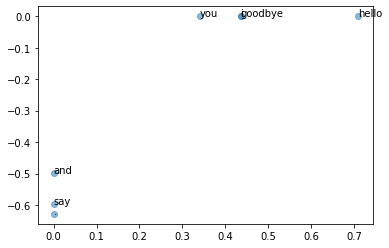

In [91]:
import matplotlib.pyplot as plt

for word, word_id in word_ids.items():
    plt.annotate(word, (U_trunc[word_id, 0], U_trunc[word_id, 1]))

plt.scatter(U_trunc[:,0], U_trunc[:, 1], alpha=0.5)


# Layer

In [142]:
def relu(x):
    return max(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def softmax(x):
    if x.dim == 1: # for a single point
        x = x - np.max(x)
        return np.exp(x) / np.sum(np.exp(x))

    if x.dim == 2: # for mini-batch
        x = x - np.max(x, axis=1, keepdims=True)
        x = np.exp(x)
        return x / np.sum(x, axis=1, keepdims=True)

    
def cross_entropy(y, t): # batch_N * |V|

    if y.ndim == 1: # for a single point
        t = t.reshape(1, t.size)  # 1 * |V|
        y = y.reshape(1, y.size)
        
    if t.size == y.size: # if t is one-hot, convert to 'id'
        t = t.argmax(axis=1)

    batch_size = len(y)
    
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class Softmax:
    def __init__(self):
        self.params = []
        self.grads = []
        self.y = None

    def forward(self, z):
        self.y = softmax(z)
        return self.y

    def backward(self, dout):
        pass
#         return self.y + self.y * dout

class Sigmoid:
    def __init__(self):
        self.params = []
        self.grads = []
        self.y = None

    def forward(self, z):
        y = sigmoid(z)
        self.y = y
        return y

    def backward(self, dout):
        return self.y * (1 - self.y) * dout


class SigmoidWithLoss:
    '''
    binary classification
    '''
    def __init__(self):
        self.params = []
        self.grads = []
        self.y = None
        self.t = None

    def forward(self, z, t): 
        self.y = sigmoid(z) # # batch_size * 1
        self.t = t # batch_size * 1 or batch_size * 2(ont-hot)
        loss= cross_entropy(np.c_[1-self.y, self.y], t)
        return loss

    def backward(self, dout=1):
        batch_size = len(self.t)
        return (self.y - self.t) * dout / batch_size


class SoftmaxWithLoss:
    def __init__(self):
        self.params = []
        self.grads = []
        self.y = None
        self.t = None

    def forward(self, z, t): 
        self.y = softmax(z) # shape: batch_N * |V|
        self.t = t # batch_size * 1 or batch_size * |V|(ont-hot)

        if self.t.size == self.y.size: # batch_size * 1
            self.t = self.t.argmax(axis=1)

        loss= cross_entropy(self.y, self.t)
        return loss

    def backward(self, dout=1):
        '''
        (y - t)/batch_size
        '''
        batch_size = len(self.t)
        dx = self.y.copy()
        dx[np.arange(batch_size), self.t]-=1

        return dx * dout / batch_size # batch_size * |V|


class MatrixMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
    
    def forward(self, x):
        W, = self.params
        out = x @ W
        self.x = x
        return out

    def backward(self, out):
        W, = self.params
        dx = out @ W.T
        dW = self.x.T @ out
        self.grads[0][...] = dw
        return dx


    


class Affine:
    '''
    density layer, fully connected layer
    '''
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zero_like(W), np.zero_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        z = x @ W + b
        self.x = x 
        return z

    def backward(self, out):
        W, b = self.params
      
        dx = out @ W.T
        dW = self.x.T @ out
        db = np.sum(out, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dx

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, out_size):

        I, H, O = input_size, hidden_size, out_size
        
        W1 = np.random.rand(I, H)
        b1 = np.random.rand(H)
        W2 = np.random.rand(H, O)
        b2 = np.random.rand(O)
    
        self.layers = [ Affine(W1, b1), Sigmoid(), Affine(W2, b2)]

        self.params = []
        for layer in self.layers:
            self.params += layer.params

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        
        return x
    

# Simple CBOW

In [100]:
def inference(contexts):
    '''
    windsize= 1
    '''
    c1, c2 = contexts
   
    D = len(c1)
    H = 3

    W_in = np.random.rand(D, H)
    W_out = np.random.rand(H, D)
    
    in_layer = MatrixMul(W_in)
    out_layer = MatrixMul(W_out)
    
    h1=in_layer.forward(c1)
    h2=in_layer.forward(c2)
    h = (h1 + h2) / len(contexts)
    s = out_layer.forward(h)
   
    return s
    
inference([[1, 0, 0,0,0,0,0,], [0,0,0,1,0,0,0,]])


array([1.06144962, 0.9572717 , 0.82174549, 0.86764326, 0.71409764,
       0.88015585, 0.8821359 ])

## construct contexts and target

In [109]:
def create_context_targets(corpus, window_size = 1):
    N = len(corpus)
    target = corpus[window_size:N-window_size]
 
    contexts = []
    for idx, w_id in enumerate(corpus[window_size:N-window_size]):
        context_w = []

        for i in range(1, window_size+1):
            left_idx = idx+window_size-i
            right_idx = idx+window_size+i

            left_id = corpus[left_idx]
            right_id = corpus[right_idx]
            
            context_w+=[left_id, right_id]

        contexts.append(context_w)

    return contexts, target


In [112]:
contexts, target = create_context_targets([0, 1, 2, 3, 4, 1, 5, 6])

contexts, target


([[0, 2], [1, 3], [2, 4], [3, 1], [4, 5], [1, 6]], [1, 2, 3, 4, 1, 5])

## convert one-hot

In [128]:
def convert_onehot(corpus, voc_size):
    '''
    convert the list of ids of a sentence to one-hot representation
    [0, 1, 2, 1, 0] => [[1,0,0], [0, 1, 0], [0, 0, 1], [0, 1, 0], [1,0,0]]
    '''

    N = corpus.shape[0] # the numer of words in a sentence or sentences

    if corpus.ndim == 1: # the numer of words in a sentence
        one_hot = np.zeros((N, voc_size))
        for idx, ids in enumerate(corpus):
            one_hot[idx, ids] = 1
    
    if corpus.ndim == 2: # the numer of sentences
        C = corpus.shape[1] # the numer of words in a sentence
        one_hot = np.zeros((N, C, voc_size))

        for idx, sent_ids in enumerate(corpus):
            for (w_idx, w_id) in enumerate(sent_ids):
                one_hot[idx, w_idx, w_id] = 1

    return  one_hot
    
    

In [132]:

target_onehot = convert_onehot(np.array(target), len(word_ids))

target_onehot.shape, target_onehot


((6, 7),
 array([[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]]))

In [133]:

contexts_onehot=convert_onehot(np.array(contexts), len(word_ids))

contexts_onehot[0], contexts_onehot.shape


(array([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]]),
 (6, 2, 7))

## learning

In [143]:
class SimpleCBOW:
    def __init__(self, voca_size, hidden_size):
        W_in = np.random.randn(voca_size, hidden_size)
        W_out = np.random.randn(hidden_size, voca_size)
        
        self.in_layer0=MatrixMul(W_in)
        self.in_layer1=MatrixMul(W_in)
        self.out_layer=MatrixMul(W_out)
        self.loss_layer=SoftmaxWithLoss()

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0+h1)*0.5 # batch_N * D
        score=self.out_layer.forward(h) # batch_N * |V|
        loss=self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        do=self.loss_layer.backward(dout)
        do = self.out_layer.backward(do)
        do*=0.5
        self.in_layer0.backward(do)
        self.in_layer1.backward(do)


In [ ]:
hidden_size = 3
window_size = 1
batch_size = 3
max_epochs = 100

sent_ids, word_ids, ids_word = preprocess('you say goodbye and i say hello.')
contexts, target = create_context_targets(sent_ids, window_size)
voc_size = len(word_ids)
contexts_onehot=convert_onehot(np.array(contexts), voc_size)

model=SimpleCBOW(voc_size, hidden_size)
for epoch in max_epochs:
    loss=0
    for i in batch_iters:
        inputs, target = batch_data
        loss+=model.forward(inputs, target)
        model.backward()
        optimizer.update()
    print(f'epoch {epoch}: loss {loss}')


# Embedding


In [148]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        '''
        forward([0, 2, 0, 4])
        '''
        W, = self.params
        out = W[idx]
        self.idx = idx
        return out

    def backward(self, dout):
        dW, = self.grads
     
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]


# NegativeSample

# RNN


$$
h_t = tanh(h_{t-1} W_h + x_t W_x + b)
$$


- batch_size: batch_N

- input dimension: D

- hidden_state dimension: H


$$
shape(h_t) = (batch\_N, H) * (H,H) + (batch\_N, D)*(D, H) + (1, H) = (batch\_N, H)
$$


In [144]:
class RNN:
    def __init__(self, W_h, W_x, b):
        self.params = [W_h, W_x, b]
        self.grads = [np.zeros_like(W_h), np.zeros_like(W_x), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev):
        '''
        x: (batch_N, D)
        h_prev: (batch_N, H)
        @return
            h_next: (batch_N, H)
        '''
        W_h, W_x, b = self.params
        h_next = h_prev @ W_h + x@W_x + b
        h_next = np.tanh(h_next)

        self.cache=(x, h_prev, h_next)

        return h_next

    def backward(self, dout):
        x, h_prev, h_next = self.cache
        W_h, W_x, b = self.params

        do = dout*(1-h_next**2)
        db = np.sum(do, axis=0)
        dx = do @ W_x.T
        dh_prev=do @ W_h.T
        dwx = x.T@do
        dwh=h_prev.T@do
        
        self.grad[0][...]=dwh
        self.grad[1][...]=dwx
        self.grad[2][...]=b

        return dx, dh_prev
        
        

In [147]:
class TimeRNN:
    def __init__(self, W_h, W_x, b, stateful=False):
        self.params = [W_h, W_x, b]
        self.grads = [np.zeros_like(W_h), np.zeros_like(W_x), np.zeros_like(b)]
        
        self.layers = []
        self.stateful=stateful
        self.h = None
        self.dh = None

    def set_state(self, prev_state):
        self.h = prev_state
    
    def reset_state(self):
        self.h = None
        

    def forward(self, xs):
        '''
        xs: (batch_N, seq_t, D)

        @return
            hs_next: (batch_N, seq_t, H)
        '''

        W_h, W_x, b = self.params
        batch_N, seq_t, D = xs.shape

        hs = np.empty((batch_N, seq_t, H))

        if self.h is None or not self.stateful:
            self.h=np.zeros((batch_N, H))
        
        for i in range(seq_t):
            layer_i = RNN(*self.params)
            self.h = layer_i.forward(xs[:, i, :], self.h)
            hs[:, i, :] = self.h
            self.layers.append(layer_i)

        return hs

    def backward(self, dhs):
        batch_N, seq_t, H = dhs.shape
        W_h, W_x, b = self.params
        D, H = W_x.shape

        dh = 0
        grads = [0, 0, 0]
        dxs = np.empty(( batch_N, seq_t, D))
        for t in reversed(range(seq_t)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :]+dh) # (batch_N, H)
            dxs[:, t, :] = dx

            # all rnn layers share the same W_h, W_x, b
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad

        self.dh = dh

        return dxs


In [149]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]

        self.layers = []
        
    def forward(self, xs):
        '''
        xs: (batch_N, seq_t, 1)
        [ [[1], 
           [0], 
           [2]
          ],
          [[0],
           [4],
           [2]
          ]
        ]
        @return
            word_vector: (batch_N, seq_t, D)
        '''
        batch_N, seq_t, _ = xs

        W, = self.params
        _, D = W.shape
        word_s = np.empty((batch_N, seq_t, D))
        for i in range(seq_t):
            layer_i = Embedding(*self.params)
            self.word = layer_i.forward(xs[:, i, :])
            word_s[:, i, :] = self.word
            self.layers.append(layer_i)
       
        return word_s
        
    def backward(self, dout):
        batch_N, seq_t, D = dout
        grad = 0
       
        for t in reversed(range(seq_t)): # there's no need to reverse the sequence
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]
        
        self.grads[0][...] = grad
